In [156]:
import numpy as np
from typing import List, Tuple, Optional
from collections import Counter
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

In [157]:
class Node:
    """
    Represents a node in KD-Tree
    """
    def __init__(self, point: np.ndarray,label: int, left: Optional['Node'] = None, right: Optional['Node'] = None):
        self.point = point # shape(n_features,)
        self.left = left
        self.right = right
        self.label = label

In [158]:
class KDTree:
    """
    Implements a KD-tree data structure for efficient nearest neighbour search
    """
    def __init__(self, points: np.ndarray, labels: np.ndarray) -> None:
        """Initialize the KD-Tree with a set of points

        Args:
            points (np.ndarray): Array of points to build the tree from
            labels (np.ndarray): Array of labels corresponding to the points
        """
        self.root = self._build_tree(points, labels)
    
    def _build_tree(self, points: np.ndarray, labels: np.ndarray, depth: int = 0) -> Optional[Node]:
        """Recursively build the KD-Tree

        Args:
            points (np.ndarray): array of points (n_samples, n_feature)
            labels (np.ndarray): array of labels (n_samples,)
            depth (int, optional): Current depth in the tree. Defaults to 0.

        Returns:
            Optional[Node]: Root node of the (sub)tree
        """
        if len(points) == 0:
            return None
        
        k = points.shape[1]
        axis = depth % k

        sorted_indices = points[:, axis].argsort()
        sorted_points = points[sorted_indices]
        sorted_labels = labels[sorted_indices]
        median = len(sorted_points) // 2

        return Node(
            point=sorted_points[median],
            label=sorted_labels[median],
            left=self._build_tree(sorted_points[:median], sorted_labels[:median], depth + 1),
            right=self._build_tree(sorted_points[median + 1:], sorted_labels[median + 1:], depth + 1)
        )

    def find_k_nearest(self, point: np.ndarray, k: int) -> List[Tuple[np.ndarray, int, float]]:
        """
        Find the k nearest neighbors to the given point.

        Args:
            point (np.ndarray): The query point. shape: (n_features,)
            k (int): The number of nearest neighbors to find.

        Returns:
            List[Tuple[np.ndarray, int, float]]: The k nearest neighbor points, their labels, and distances.
        """
        def search(node: Optional[Node], point: np.ndarray, k: int, depth: int = 0) -> List[Tuple[np.ndarray, int, float]]:
            if node is None:
                return []

            axis = depth % point.shape[0]
            next_branch = node.left if point[axis] < node.point[axis] else node.right
            other_branch = node.right if point[axis] < node.point[axis] else node.left

            best = search(next_branch, point, k, depth + 1)
            dist = np.linalg.norm(point - node.point)
            
            if len(best) < k or dist < best[-1][2]:
                best.append((node.point, node.label, dist))
                best.sort(key=lambda x: x[2])
                if len(best) > k:
                    best.pop()

            if len(best) < k or abs(point[axis] - node.point[axis]) < best[-1][2]:
                other_best = search(other_branch, point, k, depth + 1)
                best.extend(other_best)
                best.sort(key=lambda x: x[2])
                best = best[:k]

            return best

        return search(self.root, point, k)

In [159]:
class KNNClassifier:
    """
    Implements a K-Nearest Neighbors classifier using a KD-tree.
    """
    def __init__(self, k: int = 3):
        """
        Initialize the KNN classifier.

        Args:
            k (int): Number of neighbors to use for classification.
        """
        self.k = k
        self.tree = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Fit the KNN classifier to the training data.

        Args:
            X (np.ndarray): Training data features. shape: (n_samples, n_features)
            y (np.ndarray): Training data labels. shape: (n_samples,)
        """
        self.tree = KDTree(X, y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict the class labels for the provided data.

        Args:
            X (np.ndarray): Test data features. shape: (n_samples, n_features)

        Returns:
            np.ndarray: Predicted class labels. shape: (n_samples,)
        """
        predictions = []
        for point in X:
            k_nearest = self.tree.find_k_nearest(point, self.k)
            k_nearest_labels = [label for _, label, _ in k_nearest]
            most_common = Counter(k_nearest_labels).most_common(1)
            predictions.append(most_common[0][0])
        return np.array(predictions)

In [160]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [161]:
knn = KNNClassifier(k=3)
knn.fit(X_train, y_train)

In [162]:
y_pred = knn.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


# Kmeans

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional

In [164]:
class KMeans:
    def __init__(self, k:int=3, max_iters:int=100):
        """Initialize the KMeans clustering

        Args:
            k (int, optional): Number of clusters. Defaults to 3.
            max_iter (int, optional): Maximum of iterations. Defaults to 100.
        """
        self.k = k
        self.max_iters = max_iters
        self.centroids: Optional[np.ndarray] = None
        self.clusters: Optional[np.ndarray] = None

    def _initialize_centroids(self, data: np.ndarray) -> None:
        """Initialize centroids randomly

        Args:
            data (np.ndarray): Input data to cluster, shape (n_samples, n_features)
        """
        np.random.seed(42)
        random_indices = np.random.choice(data.shape[0], self.k, replace=False)
        self.centroids = data[random_indices]
    
    def _euclidean_distance(self, x1: np.ndarray, x2: np.ndarray) -> float:
        """Calculate the Euclidean distance between 2 vectors

        Args:
            x1 (np.ndarray): First vectors (n_features,)
            x2 (np.ndarray): Second vectors (n_features,)
        Returns:
            float: Euclidean distance between 2 vector 
        """
        return np.sqrt(np.sum(x1-x2) ** 2)

    def _assign_clusters(self, data: np.ndarray) -> np.ndarray:
        """Assign each data point to the nearest cluster

        Args:
            data (np.ndarray): Input data, shape (n_samples, n_features)

        Returns:
            np.ndarray: Cluster assignments for each data points, shape (n_samples,)
        """
        distances = np.array([
            [self._euclidean_distance(x, centroid) for centroid in self.centroids] for x in data
        ])

        return np.argmin(distances, axis=1)

    def _update_centroids(self, data: np.ndarray) -> np.ndarray:
        """Update centroids, based on the mean of assigned data points

        Args:
            data (np.ndarray): input data, shape (n_samples, n_features)

        Returns:
            np.ndarray: Updated centroids, shape (k, n_features).
        """
        return np.array([data[self.clusters == i].mean(axis=0) for i in range(self.k)])
    
    def _plot_clusters(self, data: np.ndarray, iteration: int) -> None:
        """Plot the current state of the clusters and centroids

        Args:
            data (np.ndarray): Input data, shape (n_samples, n_features)
            iteration (int): Current iteration number
        """
        plt.figure(figsize=(8, 6))
        plt.scatter(data[:, 0], data[:, 1], c=self.clusters, cmap='viridis', marker='o', alpha=0.6)
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], s=300, c='red', marker='x')
        plt.title(f"Iteration {iteration}")
        plt.xlabel('Sepal length')
        plt.ylabel('Sepal width')
        plt.show()

    def _plot_final_clusters(self, data: np.ndarray) -> None:
        """
        Plot the final state of clusters and centroids.

        Args:
            data (np.ndarray): Input data, shape (n_samples, n_features).
        """
        plt.figure(figsize=(8, 6))
        plt.scatter(data[:, 0], data[:, 1], c=self.clusters, cmap='viridis', marker='o', alpha=0.6)
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], s=300, c='red', marker='x')
        plt.title(f"Final result")
        plt.xlabel('Sepal length')
        plt.ylabel('Sepal width')
        plt.show()
       
    def fit(self, data: np.ndarray) -> None:
        """Fit the Kmeans model into the data

        Args:
            data (np.ndarray): Input data to cluster, shape (n_samples, n_features)
        """
        self._initialize_centroids(data)
        print(self.centroids)
        self._plot_clusters(data, iteration=0)
    
        for i in range(self.max_iters):
            self.clusters = self._assign_clusters(data)

            new_centroids = self._update_centroids(data)
            if np.allclose(self.centroids, new_centroids):
                break
            self.centroids = new_centroids
            self._plot_clusters(data, iteration=i+1)
        
        self._plot_final_clusters(data)
        print(self.centroids)

[[6.1 2.8]
 [5.7 3.8]
 [7.7 2.6]]


C:\Users\Dell\AppData\Local\Temp\ipykernel_11984\3882218828.py:69: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[:, 0], data[:, 1], c=self.clusters, cmap='viridis', marker='o', alpha=0.6)


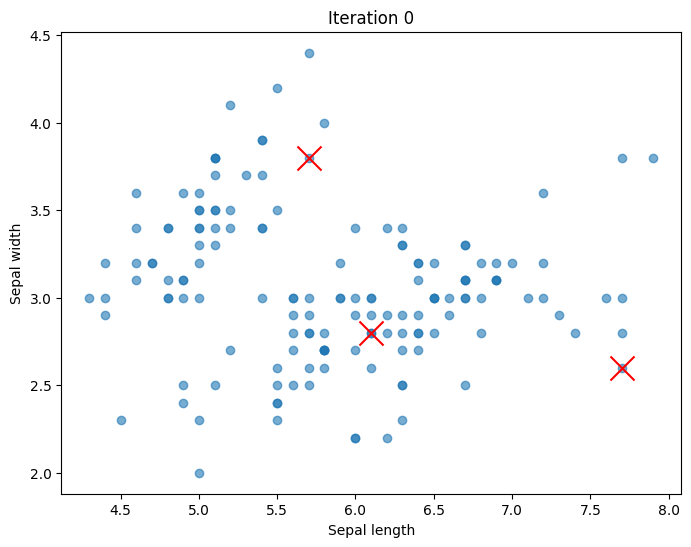

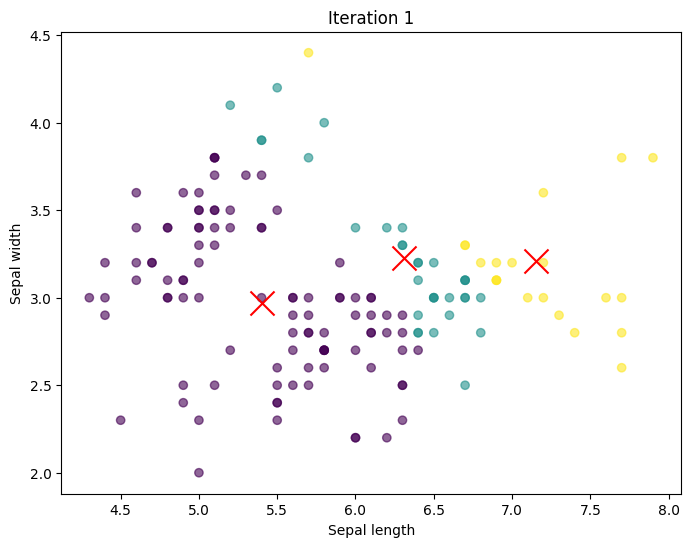

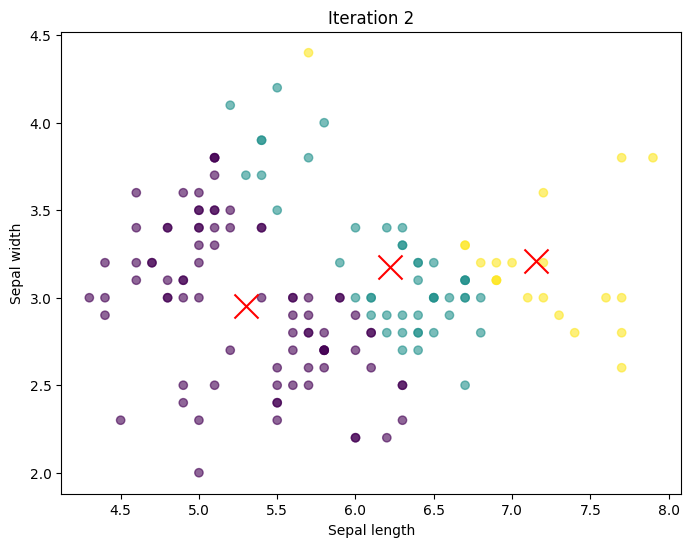

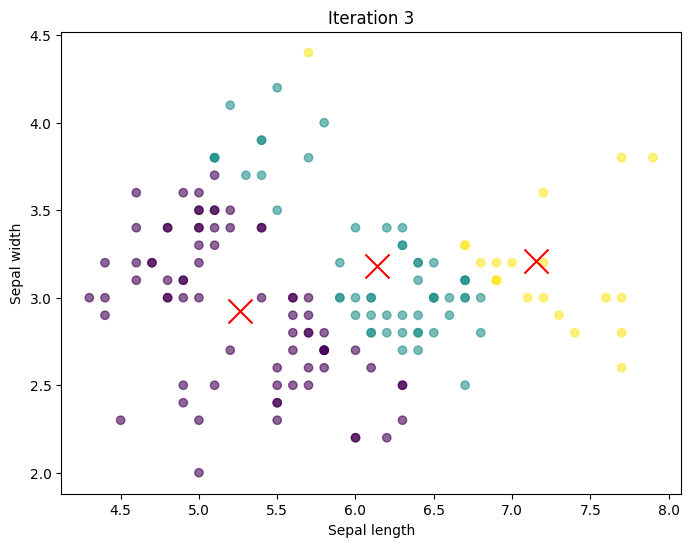

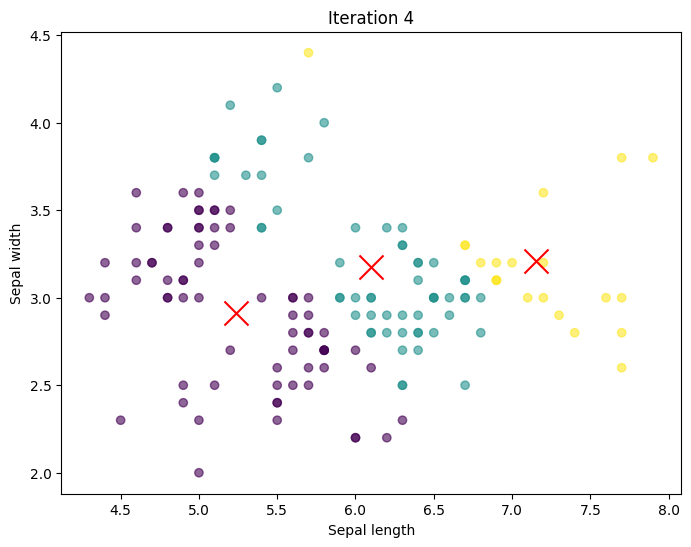

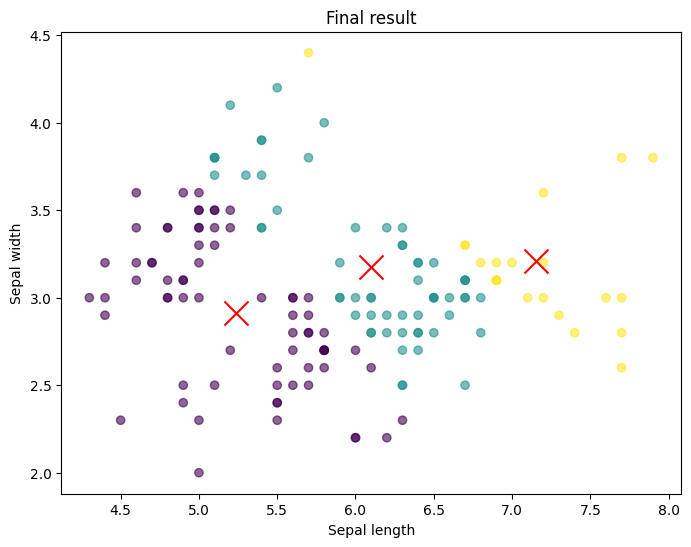

[[5.23428571 2.91142857]
 [6.1        3.17627119]
 [7.15238095 3.20952381]]


In [165]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data[:, [0,1]]
kmeans = KMeans(k = 3, max_iters=100)
kmeans.fit(X)

In [166]:
data = np.array([
    [2.0, 3.0, 1.5],
    [3.0, 3.5, 2.0],
    [3.5, 3.0, 2.5],
    [8.0, 8.0, 7.5],
    [8.5, 8.5, 8.0],
    [9.0, 8.0, 8.5],
    [1.0, 2.0, 1.0],
    [1.5, 2.5, 1.5]
])

[[3.  3.5 2. ]
 [9.  8.  8.5]
 [2.  3.  1.5]]


C:\Users\Dell\AppData\Local\Temp\ipykernel_11984\3882218828.py:69: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[:, 0], data[:, 1], c=self.clusters, cmap='viridis', marker='o', alpha=0.6)


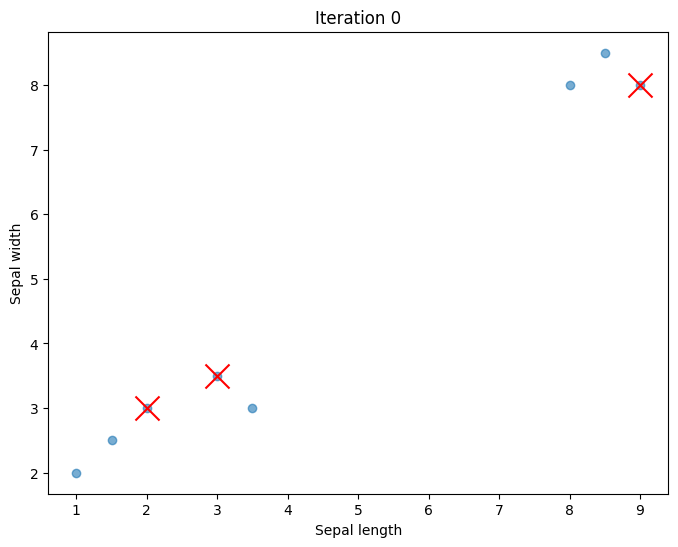

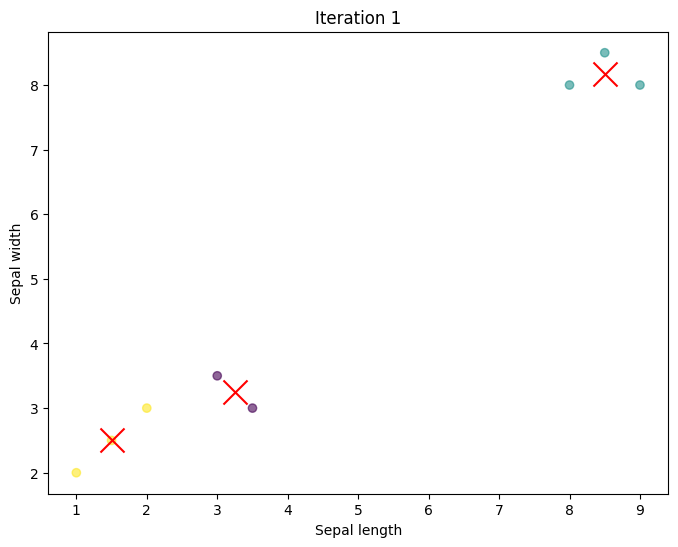

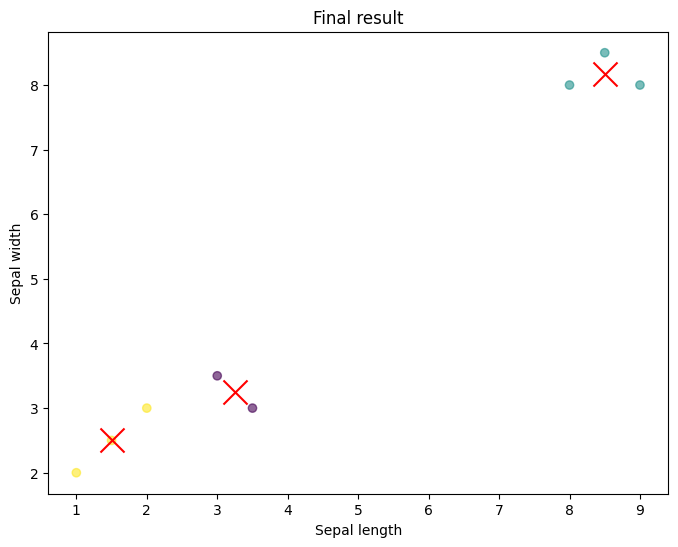

[[3.25       3.25       2.25      ]
 [8.5        8.16666667 8.        ]
 [1.5        2.5        1.33333333]]


In [167]:
kmean = KMeans(k=3, max_iters=100)
kmean.fit(data)
